# New evaluation test set playground

this file will be used to test different finetuned models. everytime it is used, please save the results in a different copy and leave this file as clean as possible 

Changes:


In [3]:
import os
import numpy as np
import json
import pandas as pd
from birdnetlib.analyzer import Analyzer
from birdnetlib.batch import DirectoryAnalyzer
import matplotlib.pyplot as plt 
import copy         # deepcopy

## test the model and extract predictions

In [4]:
# E:\Giacomo\Tovanella-20241110T120546Z-001\training_sessions\session_0\test\Certhia familiaris_Eurasian Treecreeper\20200217_160000_591.wav
# salva tutti i risultati su questo array
complete_pred_segments = {}
def on_analyze_complete(recording):
    # E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Periparus ater_Coal Tit\20200215_090000_88.wav
    audio_name = recording.path.split('\\')[-1]
    date, number, segm_id = audio_name.split('_')    # <20200215>_<090000>_<88.wav>
    segm_id = segm_id.split('.')[0]               # <88>.<wav>
    audio_name = "_".join([date, number]) + ".WAV"      # 20200215_090000.WAV
    if audio_name not in complete_pred_segments:
        complete_pred_segments[audio_name] = {}
    if segm_id not in complete_pred_segments[audio_name]:
        complete_pred_segments[audio_name][segm_id] = {}
    complete_pred_segments[audio_name][segm_id] = { 
        detection["label"]: detection["confidence"] for detection in recording.detections 
    }
    print("Analyzing ", recording.path)

def on_error(recording, error):
    print("An exception occurred: {}".format(error))
    print(recording.path)

In [5]:
complete_pred_segments = {}
model_name = "subset_20_augm_valid"
model_path = f"classifiers/official/{model_name}/CustomClassifier.tflite"
labels_path = f"classifiers/official/{model_name}/CustomClassifier_Labels.txt"
valid_path = "E:/Giacomo/Tovanella/DATASET/validation"
min_conf = 0.1

analyzer = Analyzer(
    classifier_labels_path=labels_path, 
    classifier_model_path=model_path,
)      

load_custom_models
Custom model loaded.
loading custom classifier labels
Labels loaded.
load model False
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.


In [6]:
for folder in os.listdir(valid_path):
    directory = os.path.join(valid_path, folder)

    print("Starting Watcher: ", folder)
    batch = DirectoryAnalyzer(
        directory,
        analyzers=[analyzer],
        min_conf=min_conf,
    )

    batch.on_analyze_complete = on_analyze_complete
    batch.on_error = on_error
    batch.process()

Starting Watcher:  Certhia familiaris_Eurasian Treecreeper
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20200215_110000_129.wav
Analyzing  E:\Giacomo\Tovanella\DATASET\validation\Certhia familiaris_Eurasian Treecreeper\20200215_110000_129.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20200217_160000_198.wav
Analyzing  E:\Giacomo\Tovanella\DATASET\validation\Certhia familiaris_Eurasian Treecreeper\20200217_160000_198.wav
Starting Watcher:  Dendrocopos major_Great Spotted Woodpecker
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20200217_110000_55.wav
Analyzing  E:\Giacomo\Tovanella\DATASET\validation\Dendrocopos major_Great Spotted Woodpecker\20200217_110000_55.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20200217_110000_57.wav
Analyzing  E:\Giacomo\Tovanella\DATASET\validation\Dendrocopos major_Great Spotted Woodpecker\20200217_110000_57.wav
Starting Watc

In [ ]:
# SAVE
# with open(f"classifiers/official/{model_name}/complete_pred_segments_{str(min_conf).replace('.', '_')}.json", "w") as f:
#     json.dump(complete_pred_segments, f)

In [48]:
# LOAD
# with open(f"classifiers/official/{model_name}/complete_pred_segments_{str(min_conf).replace('.', '_')}.json") as f:
#     complete_pred_segments = json.load(f)

## extract predicted and true segments 

In [18]:
# open best_threshold_by_species
with open("utils/best_threshold_by_species.json") as f:
    best_threshold_by_species = json.load(f)

In [8]:
pred_segments = copy.deepcopy(complete_pred_segments)
for audio in complete_pred_segments:
    for segm_id in complete_pred_segments[audio]:
        species_to_save = []
        for label, conf_score in complete_pred_segments[audio][segm_id].items():
            if conf_score > 0.1:
            # if conf_score > best_threshold_by_species[label]:
                species_to_save.append(label)
        pred_segments[audio][segm_id] = species_to_save

pred_segments

{'20200215_110000.WAV': {'129': ['Wind_', 'Erithacus rubecula_European Robin'],
  '166': ['Erithacus rubecula_European Robin'],
  '69': ['Wind_', 'Vegetation_']},
 '20200217_160000.WAV': {'198': ['Certhia familiaris_Eurasian Treecreeper']},
 '20200217_110000.WAV': {'55': [], '57': []},
 '20200217_090000.WAV': {'39': [], '76': []},
 '20190621_180000.WAV': {'100': ['Erithacus rubecula_European Robin',
   'Loxia curvirostra_Common Crossbill',
   'Turdus merula_Eurasian Blackbird'],
  '112': ['Erithacus rubecula_European Robin'],
  '114': ['Fringilla coelebs_Common Chaffinch',
   'Erithacus rubecula_European Robin'],
  '116': ['Erithacus rubecula_European Robin'],
  '130': ['Fringilla coelebs_Common Chaffinch'],
  '133': ['Certhia familiaris_Eurasian Treecreeper']},
 '20190608_030000.WAV': {'1': ['Turdus philomelos_Song Thrush'],
  '101': ['Turdus philomelos_Song Thrush'],
  '103': [],
  '141': ['Turdus philomelos_Song Thrush',
   'Erithacus rubecula_European Robin'],
  '159': ['Erithacus 

In [9]:
with open("utils/true_segments.json") as f:
    all_segments = json.load(f)
# filter segments in true_segments from the ones not present in pred
true_segments = {audio: { 
        key: value for key, value in all_segments[audio].items() if key in pred_segments[audio]
    } for audio in all_segments.keys() if audio in pred_segments}
true_segments["20200215_110000.WAV"]

{'69': ['Wind_'],
 '166': ['Lophophanes cristatus_Crested Tit'],
 '129': ['Certhia familiaris_Eurasian Treecreeper']}

## get results

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

audio_path = "E:/Giacomo/Tovanella/orig_segments/train"
species_list = os.listdir(audio_path)

mlb = MultiLabelBinarizer()
mlb.fit([list(species_list)])

len(mlb.classes_)

19

### side quest: get confidence scores for each label

In [11]:
conf_scores = { specie: [] for specie in species_list }
for audio in pred_segments:
    for segm, species in pred_segments[audio].items():
        for specie in species:
            if specie not in species_list:
                continue
            conf_scores[specie].append([complete_pred_segments[audio][segm][specie], specie in true_segments[audio][segm]])
# len(conf_scores["Dendrocopos major_Great Spotted Woodpecker"])

In [20]:
from sklearn.metrics import precision_recall_fscore_support

best_threshold_by_species = {}
for specie, data in conf_scores.items():
    if len(data) < 2:
        best_threshold_by_species[specie] = 0.1
        continue
    scores = np.array([x[0] for x in data])
    labels = np.array([x[1] for x in data])

    best_threshold = 0
    best_f1 = 0
    thresholds = np.linspace(scores.min(), scores.max(), 100)  # 50 soglie testate

    for threshold in thresholds:
        preds = scores >= threshold
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    best_threshold_by_species[specie] = best_threshold
    print(f"Soglia ottimale per {specie}: {best_threshold:.3f} con f1 score: {best_f1:.3f}")

Soglia ottimale per Certhia familiaris_Eurasian Treecreeper: 0.239 con f1 score: 1.000
Soglia ottimale per Dendrocopos major_Great Spotted Woodpecker: 0.132 con f1 score: 1.000
Soglia ottimale per Dryocopus martius_Black Woodpecker: 0.000 con f1 score: 0.000
Soglia ottimale per Erithacus rubecula_European Robin: 0.536 con f1 score: 0.320
Soglia ottimale per Fringilla coelebs_Common Chaffinch: 0.103 con f1 score: 0.936
Soglia ottimale per Lophophanes cristatus_Crested Tit: 0.000 con f1 score: 0.000
Soglia ottimale per Loxia curvirostra_Common Crossbill: 0.151 con f1 score: 0.600
Soglia ottimale per Pecking_: 0.648 con f1 score: 0.667
Soglia ottimale per Periparus ater_Coal Tit: 0.457 con f1 score: 0.667
Soglia ottimale per Regulus ignicapilla_Common Firecrest: 0.159 con f1 score: 0.714
Soglia ottimale per Regulus regulus_Goldcrest: 0.287 con f1 score: 0.750
Soglia ottimale per Sylvia atricapilla_Eurasian Blackcap: 0.111 con f1 score: 1.000
Soglia ottimale per Troglodytes troglodytes_Eur

In [30]:
complete_pred_segments = {}
test_path = "E:/Giacomo/Tovanella/DATASET/test"
for folder in os.listdir(test_path):
    directory = os.path.join(test_path, folder)

    print("Starting Watcher: ", folder)
    batch = DirectoryAnalyzer(
        directory,
        analyzers=[analyzer],
        min_conf=min_conf,
    )

    batch.on_analyze_complete = on_analyze_complete
    batch.on_error = on_error
    batch.process()

Starting Watcher:  Certhia familiaris_Eurasian Treecreeper
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_070000_62.wav
Analyzing  E:\Giacomo\Tovanella\DATASET\test\Certhia familiaris_Eurasian Treecreeper\20190608_070000_62.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_070000_81.wav
Analyzing  E:\Giacomo\Tovanella\DATASET\test\Certhia familiaris_Eurasian Treecreeper\20190608_070000_81.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_070000_88.wav
Analyzing  E:\Giacomo\Tovanella\DATASET\test\Certhia familiaris_Eurasian Treecreeper\20190608_070000_88.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_090000_103.wav
Analyzing  E:\Giacomo\Tovanella\DATASET\test\Certhia familiaris_Eurasian Treecreeper\20190608_090000_103.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_090000_99.wav
Analyzi

In [31]:
pred_segments = copy.deepcopy(complete_pred_segments)
for audio in complete_pred_segments:
    for segm_id in complete_pred_segments[audio]:
        species_to_save = []
        for label, conf_score in complete_pred_segments[audio][segm_id].items():
            # if conf_score > 0.1:
            if conf_score > best_threshold_by_species[label]:
                species_to_save.append(label)
        pred_segments[audio][segm_id] = species_to_save

pred_segments

{'20190608_070000.WAV': {'62': ['Fringilla coelebs_Common Chaffinch'],
  '81': ['Erithacus rubecula_European Robin'],
  '88': [],
  '-1': ['Fringilla coelebs_Common Chaffinch'],
  '1': ['Fringilla coelebs_Common Chaffinch'],
  '12': [],
  '133': ['Erithacus rubecula_European Robin'],
  '139': ['Fringilla coelebs_Common Chaffinch'],
  '144': [],
  '150': ['Fringilla coelebs_Common Chaffinch'],
  '154': [],
  '163': [],
  '18': ['Dryocopus martius_Black Woodpecker'],
  '182': [],
  '185': ['Loxia curvirostra_Common Crossbill'],
  '19': [],
  '21': ['Dryocopus martius_Black Woodpecker'],
  '22': [],
  '23': [],
  '43': ['Turdus philomelos_Song Thrush',
   'Fringilla coelebs_Common Chaffinch'],
  '45': [],
  '46': ['Fringilla coelebs_Common Chaffinch'],
  '49': [],
  '51': ['Fringilla coelebs_Common Chaffinch',
   'Dryocopus martius_Black Woodpecker'],
  '54': [],
  '57': [],
  '60': ['Fringilla coelebs_Common Chaffinch'],
  '61': ['Fringilla coelebs_Common Chaffinch'],
  '64': ['Dryocopus

In [32]:
true_segments = {audio: { 
        key: value for key, value in all_segments[audio].items() if key in pred_segments[audio]
    } for audio in all_segments.keys() if audio in pred_segments}
true_segments["20200215_110000.WAV"]

{'67': ['Wind_'],
 '68': ['Wind_'],
 '70': ['Wind_'],
 '164': ['Lophophanes cristatus_Crested Tit'],
 '165': ['Lophophanes cristatus_Crested Tit'],
 '167': ['Lophophanes cristatus_Crested Tit']}

In [33]:
# with open("utils/conf_scores.json", "w") as f:
#     json.dump(conf_scores, f)

### classification report

In [34]:
y_pred = []
y_true = []
for audio in pred_segments:
    # sort in increasing order
    sortable_true_segments = { int(key): value for key, value in true_segments[audio].items() }
    sortable_pred_segments = { int(key): value for key, value in pred_segments[audio].items() }
    sorted_true_segments = dict(sorted(sortable_true_segments.items()))
    sorted_pred_segments = dict(sorted(sortable_pred_segments.items()))
    y_true.append(mlb.transform(sorted_true_segments.values()))     # apply transform on every label of every segment
    y_pred.append(mlb.transform(sorted_pred_segments.values()))     # apply transform on every label of every segment

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Phylloscopus collybita_Common Chiffchaff'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Phylloscopus trochilus_Willow Warbler'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Phylloscopus collybita_Common Chiffchaff', 'Prunella modularis_Dunnock'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Phylloscopus collybita_Common Chiffchaff', 'Turdus viscivorus_Mistle Thrush'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\sit

In [35]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
with open(f"classifiers/official/{model_name}/classification_report.json", "w") as f:
    json.dump(report, f)

report_df = pd.DataFrame(report).T
report_df

,precision,recall,f1-score,support
Certhia familiaris_Eurasian Treecreeper,0.063636,0.388889,0.109375,18.0
Dendrocopos major_Great Spotted Woodpecker,0.333333,0.300000,0.315789,10.0
Dryocopus martius_Black Woodpecker,0.034091,0.272727,0.060606,11.0
Erithacus rubecula_European Robin,0.288889,0.220339,0.250000,59.0
Fringilla coelebs_Common Chaffinch,0.826087,0.314917,0.456000,905.0
Lophophanes cristatus_Crested Tit,0.035088,0.380952,0.064257,21.0
Loxia curvirostra_Common Crossbill,0.346939,0.809524,0.485714,21.0
Muscicapa striata_Spotted Flycatcher,0.555556,0.958904,0.703518,73.0
Pecking_,0.571429,0.363636,0.444444,11.0
Periparus ater_Coal Tit,0.277778,0.131579,0.178571,38.0


### auc roc

In [36]:
y_pred_conf = []

for audio in pred_segments:
    scores_pred = []
    for segm, predictions in complete_pred_segments[audio].items():
        segm_conf_score = np.zeros(len(mlb.classes_))  # Vettore inizializzato a 0 per tutte le classi

        for pred, conf in predictions.items():
            binary_vector = mlb.transform([[pred]])[0]  # Convertiamo in binario (shape: (n_classes,))
            segm_conf_score += binary_vector * conf  # Moltiplichiamo per il confidence score

        scores_pred.append(segm_conf_score)  # Ogni segmento ora ha un array della stessa lunghezza di n_classes
    
    y_pred_conf.append(np.array(scores_pred))  # Lista di array uniformi

# Convertiamo in un array 2D
y_pred_conf = np.vstack(y_pred_conf)

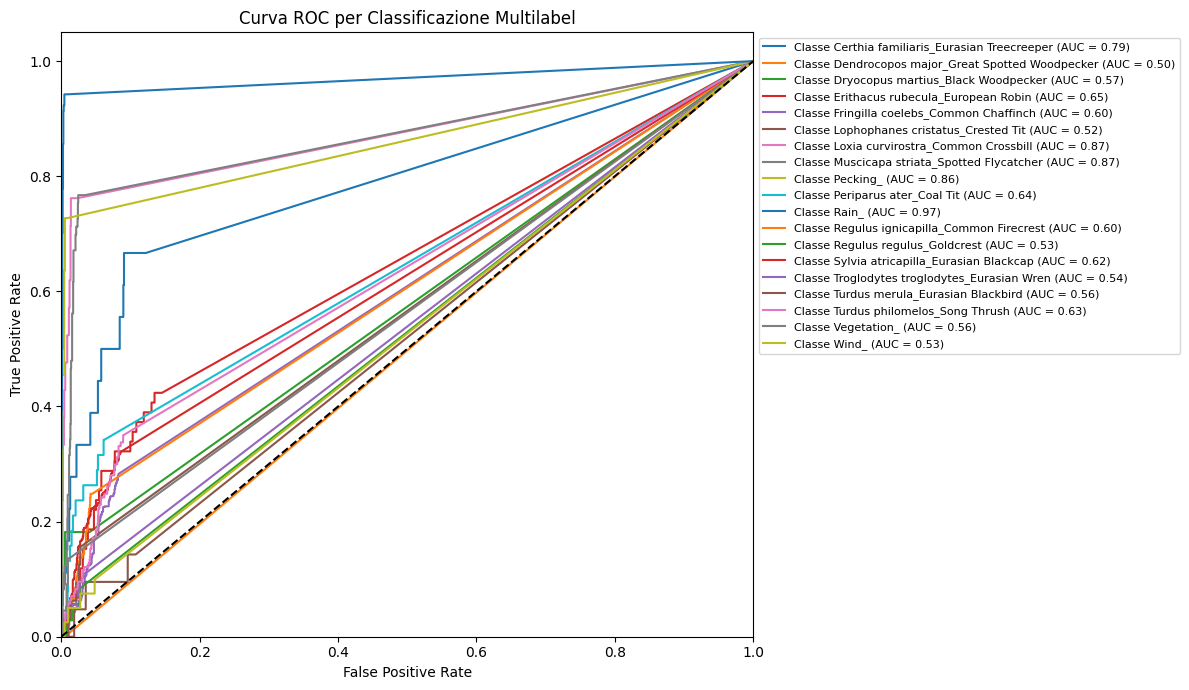

In [37]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 7))  # Aumenta la dimensione
n_classes = len(mlb.classes_)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_conf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {mlb.classes_[i]} (AUC = {roc_auc:.2f})')

# Linea di riferimento
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC per Classificazione Multilabel')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.show()

In [38]:
roc_data = {}

n_classes = len(mlb.classes_)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_conf[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Salviamo i dati in un dizionario
    roc_data[mlb.classes_[i]] = {
        "fpr": fpr.tolist(),  # Converti in lista per compatibilità JSON
        "tpr": tpr.tolist(),
        "auc": roc_auc
    }
    
with open(f"classifiers/official/{model_name}/roc_auc.json", "w") as f:
    json.dump(roc_data, f)